# Epidemic mitigation project - environment tutorial

For question 1 we reuse the tutorial environment

### Importing the relevant packages
If the environment is correctly setup you should be able to sucessfully import the following packages.

In [1]:
from gym import spaces
import matplotlib.pyplot as plt

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn
import seaborn as sns

SEED = 69
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

%matplotlib inline

In [2]:
# Some code to make the picture a bit nicer for the report
SAVE_REPORT = True
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
# does need cm-super, dvipng and latex to be installed
if SAVE_REPORT:
        plt.rcParams.update(tex_fonts)

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.
    from: https://jwalton.info/Embed-Publication-Matplotlib-Latex/

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27
    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2
    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)
    return fig_dim


['Lausanne', 'Geneva', 'Sion', 'Neuchâtel', 'Basel', 'Bern', 'Lücern', 'St-Gallen', 'Zürich']


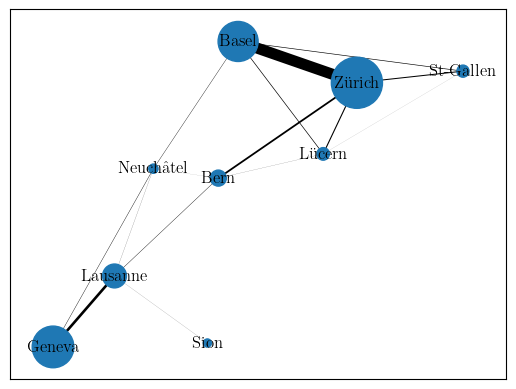

In [3]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map
print(dyn.cities)
dyn.draw_map()

## Implementing the unmitigated agent

Properly defining the action and observation spaces will allow us to sample random actions, observations from them easily. This will be useful to automatically define the size of our neural networks, and to implement epsilon-greedy exploration schemes. In order to better understand the action and observation space, read the corresponding sections in the [OpenAI Gym Documentation](https://www.gymlibrary.dev/). 

Number cities: 9 and env_step_length: 7
sampled action : 4
Sampled observation (shape (2, 9, 7)) first dimension is infected & dead


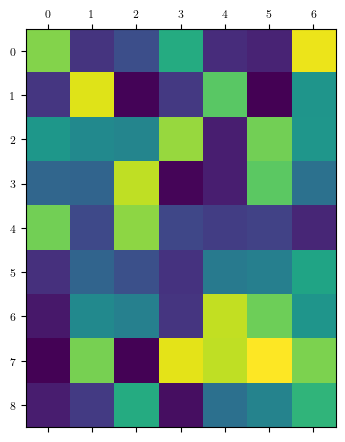

In [4]:
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
print(f"Number cities: {dyn.n_cities} and env_step_length: {dyn.env_step_length}")
print(f"sampled action : {action_space.sample()}")
print(f"Sampled observation (shape {observation_space.sample().shape}) first dimension is infected & dead")
plt.matshow(observation_space.sample()[0,:,:])
plt.show()


In the following cell we implement preprocessing functions for actions and observations. The action preprocessing function takes an int and returns an action dictionary. The observation preprocessing function takes an observation object, and returns a torch tensor.

In [5]:
SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4


def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    return torch.Tensor(np.stack((infected, dead, confined))).unsqueeze(0)

In the following cell we **instanciate an environment with set action and observation spaces attributes**. This will allow for sampling the env for example actions and observations, which we use for random actions in the example dummy agent. The action preprocessor and the observation preprocessor that we defined below are also passed to the environment.

In [6]:
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

In the following cell we show how to subclass the agent class. (Here to create a fully random dummy agent with 5 actions).

In [7]:
class UnmitigatedAgent(Agent):
    def __init__(self,  env:Env):
        self.env = env
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def act(self, obs):
        # The unmitigated agent always takes the same action, i.e. do nothing
        return ACTION_NULL

#### Running with this agent

In [8]:
agent = UnmitigatedAgent(env)

""" Run the simulation """
log = []
finished = False
obs, info = env.reset(SEED)
deaths = []
rewards = []
agent.reset()
agent.epsilon = 0
while not finished:
    # Each action is done per week
    action = agent.act(obs)
    # Meaning also the log info is per week
    obs, R, finished, info = env.step(action)
    deaths.append(info.total.dead)
    rewards.append(R)
    log.append(info) # save the information dict for logging

""" Parse the logs """
deaths = np.array(deaths)
rewards = np.array([r.numpy()[0] for r in rewards])
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}


1. A plot of variables s e i r d per week total over time, where time is measured in weeks and all the variables share the y axis scaling.

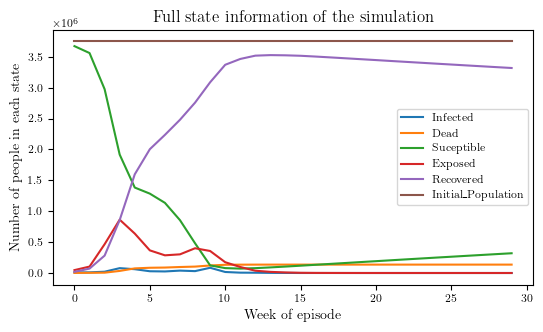

In [9]:
size = set_size(400) if SAVE_REPORT else (8, 5)
fig = plt.figure(figsize=size)
[plt.plot(y) for y in total.values()]
plt.legend([k.title() for k in total.keys()])
plt.title('Full state information of the simulation')
plt.ylabel('Number of people in each state')
plt.xlabel('Week of episode')
plt.tight_layout()
if SAVE_REPORT:
    plt.savefig('figures/created/Q1-fullState.png', dpi=300)
else:
    plt.show()

2. A plot of variables i d total over time, where time is measured in weeks and all the variables share the y axis scaling.

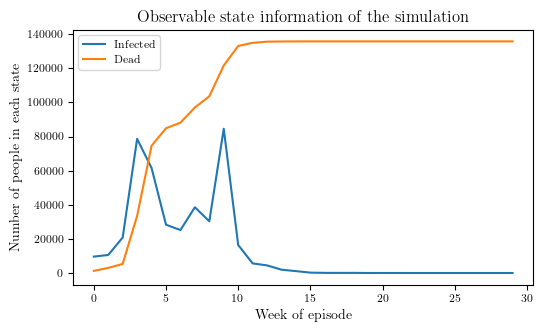

In [10]:
size = set_size(400) if SAVE_REPORT else (8, 5)
fig = plt.figure(figsize=size)
[plt.plot(total[y]) for y in ['infected','dead']]
plt.legend(['Infected','Dead'])
plt.title('Observable state information of the simulation')
plt.ylabel('Number of people in each state')
plt.xlabel('Week of episode')
plt.tight_layout()
if SAVE_REPORT:
    plt.savefig('figures/created/Q1-observableState.png', dpi=300)
else:
    plt.show()

3. A set of plots of variables i d city over time, where time is measured in weeks (one subplot per-city, variables share the y-scaling per-city).

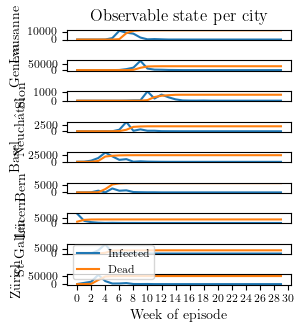

In [11]:
# No modification necessary from the tutorial code
from matplotlib.ticker import MultipleLocator

size = set_size(400) if SAVE_REPORT else (14, 10)
fig = plt.figure(figsize=size)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Zürich'].set_xlabel('Week of episode')
ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))
ax_right['Lausanne'].set_title('Observable state per city')
plt.legend(['Infected','Dead'])
fig.tight_layout()
if SAVE_REPORT:
    plt.savefig('figures/created/Q1-observableStatePerCity.png', dpi=300)
else:
    plt.show()

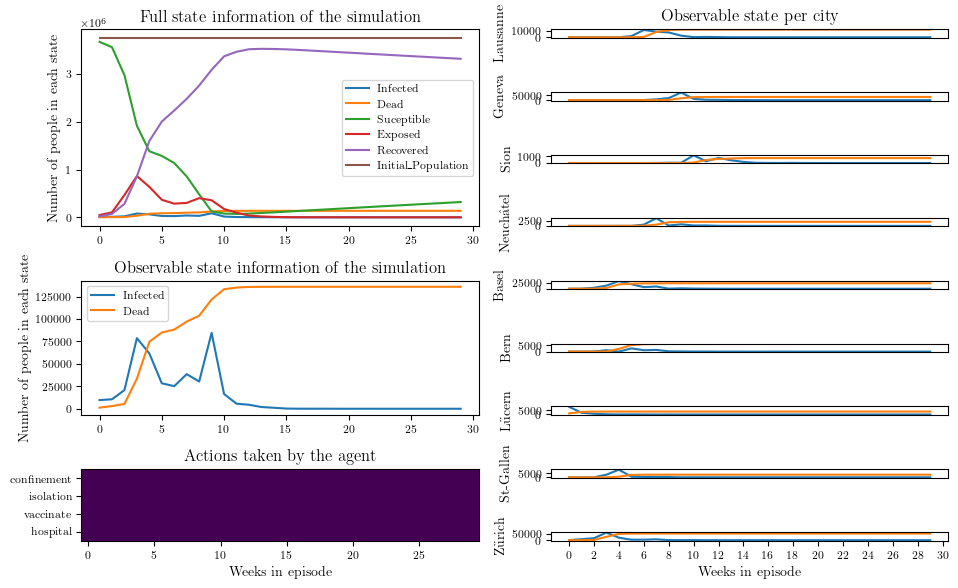

In [16]:
# Try single plot
size = set_size(700) if SAVE_REPORT else (14, 10)
fig = plt.figure(figsize=size)
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend([t.title() for t in total.keys()])
ax_leftstate.set_title('Full state information of the simulation')
ax_leftstate.set_ylabel('Number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['Infected','Dead'])
ax_leftobs.set_title('Observable state information of the simulation')
ax_leftobs.set_ylabel('Number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions taken by the agent')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('Weeks in episode')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Zürich'].set_xlabel('Weeks in episode')
ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))
ax_right['Lausanne'].set_title('Observable state per city')

fig.tight_layout()
fig.tight_layout()
if SAVE_REPORT:
    plt.savefig('figures/created/Q1-complete.png', dpi=300)
else:
    plt.show()

### Histogram functions
Just to look at some information of the pure unmitigated agent runs --> should help for the discussion.

In [13]:
print(f"Size of deaths array: {len(deaths)} and size of rewards array: {len(rewards)}")

Size of deaths array: 30 and size of rewards array: 30


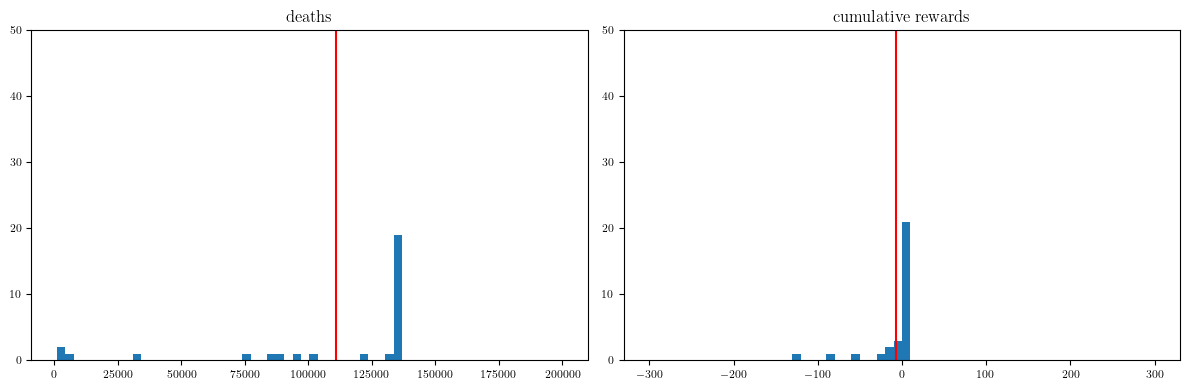

Average death number: 110857.63333333333
Average cumulative reward: -6.601480007171631


In [14]:
""" As it is deterministic we really don't need to get anything else than deaths and rewards """
""" Plot example """
fig, ax = plt.subplots(1,2,figsize=(12,4))
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
hist_avg(ax[0], deaths,'deaths')
hist_avg(ax[1], rewards,'cumulative rewards')
fig.tight_layout()
plt.show()

""" Print example """
print(f'Average death number: {np.mean(deaths)}')
print(f'Average cumulative reward: {np.mean(rewards)}')